# Making a Plummer Sphere

Okay, a Plummer sphere is a spherically symmetric model of a self-gravitating system defined by its mass distribution function,
$$
f(E) = \frac{24 \sqrt{2}}{7 \pi^3} \frac{a^2}{G^5 M^4} (-E)^{7/2}.
$$
The mass density follows from the distribution function and is
$$
\rho(r) = \frac{3}{4\pi} \frac{M}{a^3} \frac{1}{(1 + r^2/a^2)^{5/2}},
$$
We'll work in units where the $G = 1$ and we'll set $M = a = 1$ for convenience.

Now, the cumulative mass $M(r)$ is how much mass is contained within a radius $r$:
$$
M(r) = 4\pi \int_0^r \rho(r) r^2 dr = \frac{r^3}{(1 + r^2)^{3/2}}.
$$

Text(0, 0.5, 'r')

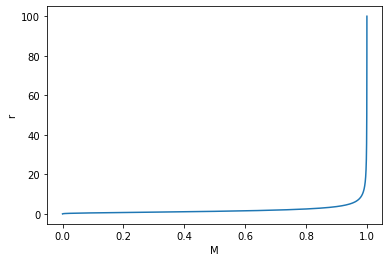

In [4]:
import numpy as np
import matplotlib.pyplot as plt

r = np.linspace(0.001, 100, 1000)
rho = 3/4/np.pi * np.power(1 + r**2, -5/2)
M = r**3 * np.power(1 + r**2, -3/2)

#plt.plot(r, rho)
plt.plot(M, r)
plt.xlabel("M")
plt.ylabel("r")

So, I think we have to draw random numbers for M(r) -- we want to choose a radius such that they fall in this probability distribution.  To do that we invert the mass distribution,
$$
r = (M^{-2/3} - 1)^{-1/2},
$$
and draw random numbers for $M$ that are uniform (between zero and the total mass) and compute the radius that each mass will be at.  Let's try!

/tmp/ipykernel_5218/3928448775.py:32: RuntimeWarning: divide by zero encountered in log10
  return np.log10(radii), np.log10(density)


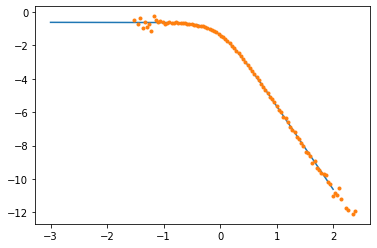

In [5]:
rng = np.random.default_rng()

N = 100000
# create an array of cumaltive masses M
M = rng.random(N)

# then turn that into radii
radii = np.power(np.power(M, -2/3) - 1, -1/2)

# the total mass is one, so each particle has mass 1/N
masses = np.ones(N)/N

# does this reproduce the density profile?
def calc_density_log(r, masses, num_bins = 100):
    rmax = np.max(r) + 1e-5
    rmin = np.min(r)
    dr = np.log10(rmax / rmin) / num_bins
    
    density = np.zeros(num_bins)
    for i in range(N):
        pos = int( (np.log10(r[i]) - np.log10(rmin)) / dr)
        density[pos] += masses[i]
    
    radii = np.zeros(num_bins)
    for i in range(num_bins):
        radii[i] = np.power(10.0, np.log10(rmin) + 0.5 * dr + dr*i)
        ri = np.power(10.0, dr*i) * rmin
        rp1 = np.power(10.0, dr) * ri
        volume = 4.0 / 3.0 * np.pi * ( np.power(rp1, 3.0) - np.power(ri, 3.0) )
        
        density[i] /= volume
    return np.log10(radii), np.log10(density)

rbin, rhobin = calc_density_log(radii, masses)

plt.plot(np.log10(r), np.log10(rho))
plt.plot(rbin, rhobin, '.')


That's nice, but what I realy want is to increase the resolution at the centre of the system -- where the black hole will grow.  Maybe we can do that by adjusting the original mass random numbers -- we'll square them so that there's more numbers with smaller mass, which will lead to more particles at smaller radii.  Let's try:

/tmp/ipykernel_5218/3928448775.py:32: RuntimeWarning: divide by zero encountered in log10
  return np.log10(radii), np.log10(density)


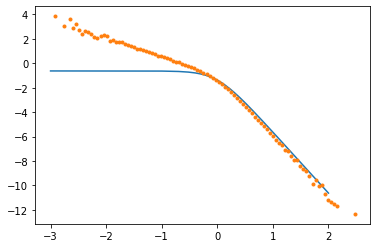

In [6]:
# create an array of cumaltive masses M
M = rng.random(N)**2

# then turn that into radii
radii = np.power(np.power(M, -2/3) - 1, -1/2)

# check
rbin, rhobin = calc_density_log(radii, masses)

plt.plot(np.log10(r), np.log10(rho))
plt.plot(rbin, rhobin, '.')

Uh oh.  There's more particle near the centre so there's more mass, and the density profile is wrong.  But maybe we can adjust the masses to account for this?  We'll set each mass to the square root of the cumulative mass to undo the earlier square:

/tmp/ipykernel_5218/3928448775.py:32: RuntimeWarning: divide by zero encountered in log10
  return np.log10(radii), np.log10(density)


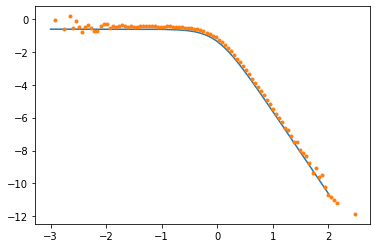

In [7]:
masses = np.sqrt(M) / np.sum(M)

# check
rbin, rhobin = calc_density_log(radii, masses)

plt.plot(np.log10(r), np.log10(rho))
plt.plot(rbin, rhobin, '.')

Well, that's not bad!  The density is a little higher than the theoretical, but looks pretty good to me.  Let's try it out in nbody-plummer.py.

In [1]:
!python ./nbody-plummer.py -n 100000 plum_orig.dat
!python ./nbody-plummer.py -n 100000 -m plum_unequal.dat

Writing nbody system to file plum_orig.dat (as binary)
--Wrote 100000 particles at time 0.0
Writing nbody system to file plum_unequal.dat (as binary)
--Wrote 100000 particles at time 0.0


In [12]:
!nbody-density.py plum_orig.dat
!nbody-density.py plum_unequal.dat
!nbody-velocity-dispersion.py plum_orig.dat
!nbody-velocity-dispersion.py plum_unequal.dat

Reading nbody system from file plum_orig.dat
--Read 100000 particles at time 0.0
Binning in radial shells with logarithmic spacing
  r_min =  0.015, r_max = 38.683
Reading nbody system from file plum_unequal.dat
--Read 100000 particles at time 0.0
Binning in radial shells with logarithmic spacing
  r_min =  0.001, r_max = 26.871
Reading nbody system from file plum_orig.dat
--Read 100000 particles at time 0.0
Binning in radial shells with logarithmic spacing
  r_min =  0.015, r_max = 38.683
Reading nbody system from file plum_unequal.dat
--Read 100000 particles at time 0.0
Binning in radial shells with logarithmic spacing
  r_min =  0.001, r_max = 26.871


Text(0, 0.5, 'log rho')

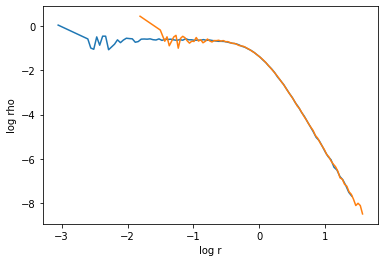

In [10]:
r1, rho1 = np.loadtxt("plum_orig.den", unpack=True)
r2, rho2 = np.loadtxt("plum_unequal.den", unpack=True)

plt.plot(r2, rho2)
plt.plot(r1, rho1)
plt.xlabel("log r")
plt.ylabel("log rho")

Text(0, 0.5, 'log vel disp')

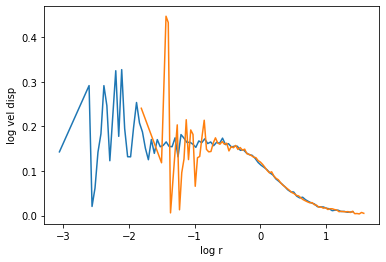

In [14]:
r1, vel1 = np.loadtxt("plum_orig.vel", unpack=True)
r2, vel2 = np.loadtxt("plum_unequal.vel", unpack=True)

plt.plot(r2, vel2)
plt.plot(r1, vel1)
plt.xlabel("log r")
plt.ylabel("log vel disp")

So, for both density and velocity dispersion, the unequal mass scheme is much better, even if the velocity dispersion is still pretty messy close in.  Nothing left to do but try it in a simulation -- first without a black hole to see if anything crazy happens (it might!) and then with a growing black hole. 